# Principle Component Explained Variance
### Matt Harrington

In [6]:
from subsets import *
from coin_helpers import load_coins, simplify
returns = load_coins('pairs/', top_50)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Log-Returns Head:                           BTC       ETH  BCH  BNB  LINK  DOT  ADA  LTC  EOS  \
open_time                                                                     
2017-08-17 04:01:00  0.000000  0.000000  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
2017-08-17 04:02:00  0.004467 -0.003759  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
2017-08-17 04:03:00 -0.004467  0.000000  NaN  NaN   NaN  NaN  NaN  NaN  NaN   

                     XMR  ...  UMA  ONT  YFI  SNX  FTT  BTT  ALGO  DGB  DOGE  \
open_time                 ...                                                  
2017-08-17 04:01:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   
2017-08-17 04:02:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   
2017-08-17 04:03:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   

                     REN  
open_time                 
2017-08-17 04:01:00  NaN  
2017-08-17 04:02:00  NaN  
2017-08-17 04:03:00  NaN  

[3 rows x 36 columns]


In [7]:
hour_ret = simplify(returns, '1h')
day_ret = simplify(returns, '1D')

In [8]:
n = 365
twoyr, oneyr = [], []
for c in day_ret.columns:
    nulls = day_ret[c].isnull().sum()
    lengs = day_ret[c].shape[0]
    if lengs - nulls > n:
        oneyr.append(c)
        if lengs - nulls > 2*n:
            twoyr.append(c)

nyr = len(oneyr)
nall = len(returns.columns)
p = round(100 * nyr / nall, 2)
print("{0} of {1} ({2}%) have more than {3} days of data".format(nyr, nall, p, n))
print("{0} of {1} ({2}%) have more than {3} days of data".format(len(twoyr), nall, p, 2 * n))

26 of 36 (72.22%) have more than 365 days of data
14 of 36 (72.22%) have more than 730 days of data


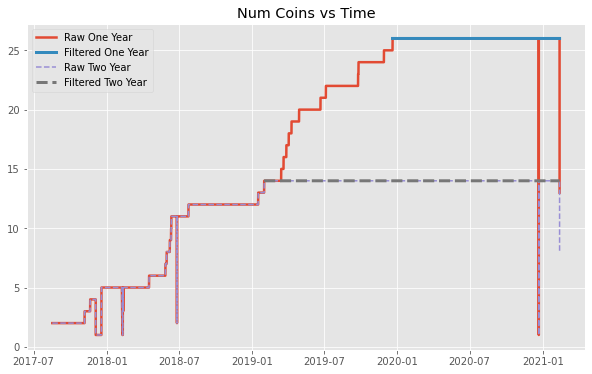

In [9]:
# Grab historical subset and drop bad days
twoall = returns[twoyr].count(axis=1) 
tpca = returns[twoyr].dropna(how='any').count(axis=1)
oneall = returns[oneyr].count(axis=1)
opca = returns[oneyr].dropna(how='any').count(axis=1)

# Illustrate relationship
fig = plt.figure(figsize=(10,6))
plt.plot(oneall, label='Raw One Year', lw=2.5)
plt.plot(opca, label='Filtered One Year', lw='3')
plt.plot(twoall, label='Raw Two Year', ls='--')
plt.plot(tpca, label='Filtered Two Year', ls='--', lw='3')
plt.title("Num Coins vs Time")
plt.legend()
plt.show()

In [10]:
from sklearn.decomposition import PCA

# the Oxford paper suggests setting T s.t. T / N >= 1

def numpy_ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def linear_pca_explained_var(ts, samps, T = 14, ma_window = 10):
    
    N = max(ts.dropna(how='any').count(axis=1))
    print(N)

    for samp in samps: 
        forpca = simplify(ts, samp).dropna(how='any')
        n_windows = forpca.shape[0] - T + 1
        ma_window = int(n_windows / 30)

        # print(n_windows, ma_window)
        
        pca = PCA(n_components=N)
        expl_vars = np.zeros(n_windows)
        windows = forpca.rolling(window=T)
        for i, window in enumerate(windows):
            if window.shape[0] < T: continue
            expl_vars[i - T] = pca.fit(window).explained_variance_ratio_[0]
        ma = numpy_ma(expl_vars, ma_window)

        fig = plt.figure(figsize=(12,8))
        plt.plot(forpca.index[-n_windows:], expl_vars,
                 label='Explained {}-Period Variance'.format(T))
        plt.plot(forpca.index[-ma.shape[0]:], ma, 
                 color='black', lw=2.5, label="{}-Period MA".format(ma_window))
        plt.title("{}-Interval LPCA Explained Variance for Oldest {} Coins".format(samp, len(forpca.columns)))
        plt.legend()
        plt.ylim([0, 1])
        plt.show()

14


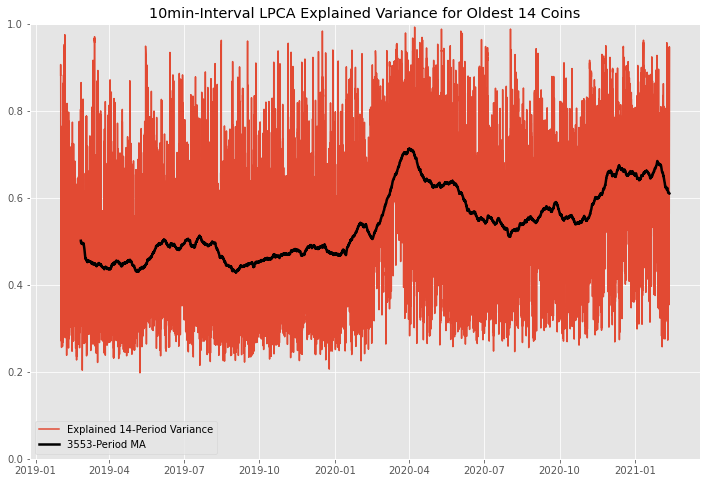

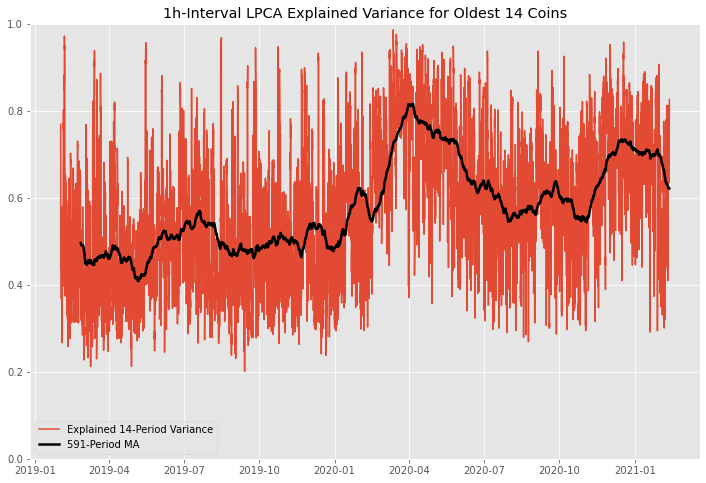

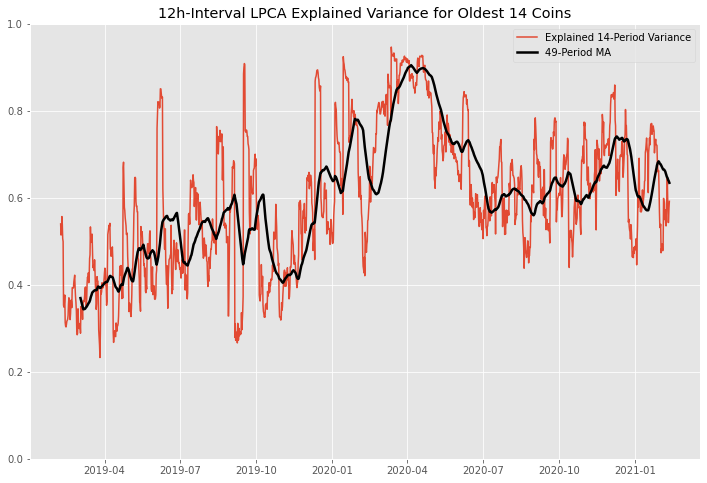

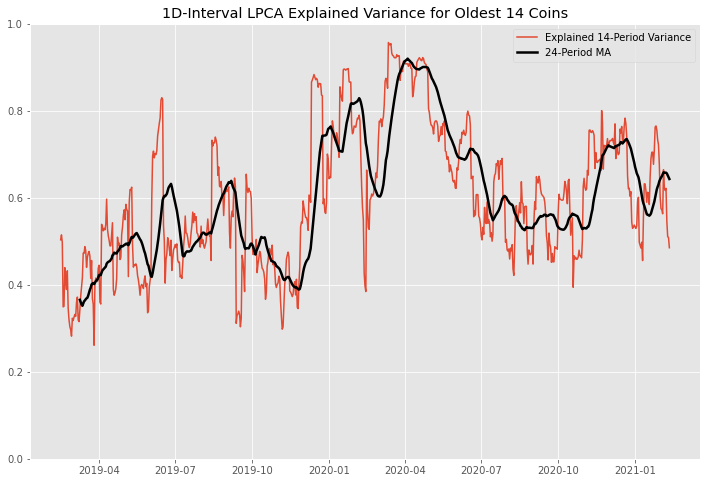

In [12]:
linear_pca_explained_var(returns[twoyr], ['10min', '1h', '12h', '1D'], 14)

In [ ]:
def sample_aggregated_linear_pca_explained_var(ts, samps, T = 14, ma_window = 10):
    
    N = max(ts.dropna(how='any').count(axis=1))
    print(N)

    fig = plt.figure(figsize=(12,8))

    for samp in samps: 
        forpca = simplify(ts, samp).dropna(how='any')
        n_windows = forpca.shape[0] - T + 1
        ma_window = int(n_windows / 30)

        # print(n_windows, ma_window)
        
        pca = PCA(n_components=N)
        expl_vars = np.zeros(n_windows)
        windows = forpca.rolling(window=T)
        for i, window in enumerate(windows):
            if window.shape[0] < T: continue
            expl_vars[i - T] = pca.fit(window).explained_variance_ratio_[0]
        ma = numpy_ma(expl_vars, ma_window)
        
        plt.plot(forpca.index[-ma.shape[0]:], ma, label="{}|{}-Period MA".format(samp, ma_window))
    
    plt.title("LPCA Explained Variance for Oldest {} Coins".format(len(forpca.columns)))
    plt.legend()
    plt.ylim([0, 1])
    plt.show()

In [ ]:
sample_aggregated_linear_pca_explained_var(returns[twoyr], ['15min', '1h', '3h', '6h', '12h', '1D'], 14)